# Smoothify vs Shapely's simplify(): A Comparison

This notebook compares **Smoothify** with **Shapely's `simplify()`** method for processing vector geometries derived from raster data (e.g., segmentation masks from ML models).

## Key Differences

**Shapely's `simplify()`** uses the Douglas-Peucker algorithm:
- Removes vertices to reduce complexity
- Creates generalized shapes but maintains sharp angles
- Does NOT preserve area
- Does NOT preserve holes area

**Smoothify** uses a pipeline that:
- Adds vertices to create smooth curves
- Preserves area
- Preserves hole area
- More consistent with original geometry
- Can join adjacent polygons

## Setup

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from smoothify import smoothify

# Set up plotting style
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 10

In [2]:
# Helper function for consistent plotting
def plot_comparison(
    original,
    shapely_result,
    smoothify_result,
    title,
    metric_name="Area",
    show_hole_metrics=False,
):
    """Plot 3-panel comparison: original, shapely overlay, smoothify overlay"""
    import matplotlib.patches as mpatches

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Original
    gpd.GeoSeries([original]).plot(
        ax=axes[0], color="lightblue", edgecolor="darkblue", linewidth=2
    )
    axes[0].set_title(
        f"Original (Pixelated)\n{metric_name}: {original.area:.1f}\nVertices: {len(original.exterior.coords)}",
        fontweight="bold",
        fontsize=12,
    )
    axes[0].set_aspect("equal")
    axes[0].grid(True, alpha=0.3, linewidth=0.5)

    # Overlay: Original vs Shapely
    gpd.GeoSeries([original]).plot(
        ax=axes[1],
        facecolor="lightblue",
        edgecolor="blue",
        linewidth=2,
        alpha=0.4,
    )
    gpd.GeoSeries([shapely_result]).plot(
        ax=axes[1],
        facecolor="none",
        edgecolor="red",
        linewidth=3,
    )

    change_pct = (shapely_result.area - original.area) / original.area * 100
    axes[1].set_title(
        f"Overlay: Original vs Shapely simplify()\n{metric_name}: {shapely_result.area:.1f} ({change_pct:+.1f}%)\nVertices: {len(shapely_result.exterior.coords)}",
        fontweight="bold",
        fontsize=12,
    )
    axes[1].set_aspect("equal")
    # Create manual legend patches
    blue_patch = mpatches.Patch(
        facecolor="lightblue", edgecolor="blue", alpha=0.4, label="Original"
    )
    red_patch = mpatches.Patch(
        facecolor="none", edgecolor="red", linewidth=3, label="Shapely simplify()"
    )
    axes[1].legend(handles=[blue_patch, red_patch], loc="upper right", fontsize=10)
    axes[1].grid(True, alpha=0.3, linewidth=0.5)

    # Overlay: Original vs Smoothify
    gpd.GeoSeries([original]).plot(
        ax=axes[2],
        facecolor="lightblue",
        edgecolor="blue",
        linewidth=2,
        alpha=0.4,
    )
    gpd.GeoSeries([smoothify_result]).plot(
        ax=axes[2],
        facecolor="none",
        edgecolor="darkgreen",
        linewidth=3,
    )

    diff_pct = abs(smoothify_result.area - original.area) / original.area * 100
    axes[2].set_title(
        f"Overlay: Original vs Smoothify\n{metric_name}: {smoothify_result.area:.1f} ({diff_pct:.3f}% diff)\nVertices: {len(smoothify_result.exterior.coords)}",
        fontweight="bold",
        fontsize=12,
    )
    axes[2].set_aspect("equal")
    # Create manual legend patches
    green_patch = mpatches.Patch(
        facecolor="none", edgecolor="darkgreen", linewidth=3, label="Smoothify"
    )
    axes[2].legend(handles=[blue_patch, green_patch], loc="upper right", fontsize=10)
    axes[2].grid(True, alpha=0.3, linewidth=0.5)

    plt.suptitle(title, fontsize=16, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

    # Print metrics
    print("\n" + "=" * 70)
    print(f"{metric_name.upper()} COMPARISON")
    print("=" * 70)
    print(f"Original:                {original.area:>10.2f} units²")
    print(
        f"Shapely simplify():      {shapely_result.area:>10.2f} units² ({change_pct:>+7.2f}%)"
    )
    print(
        f"Smoothify:               {smoothify_result.area:>10.2f} units² ({diff_pct:>7.2f}% diff)"
    )

## Example 1: Area Preservation

**Key Feature**: Smoothify preserves polygon area, while `simplify()` can significantly change it.

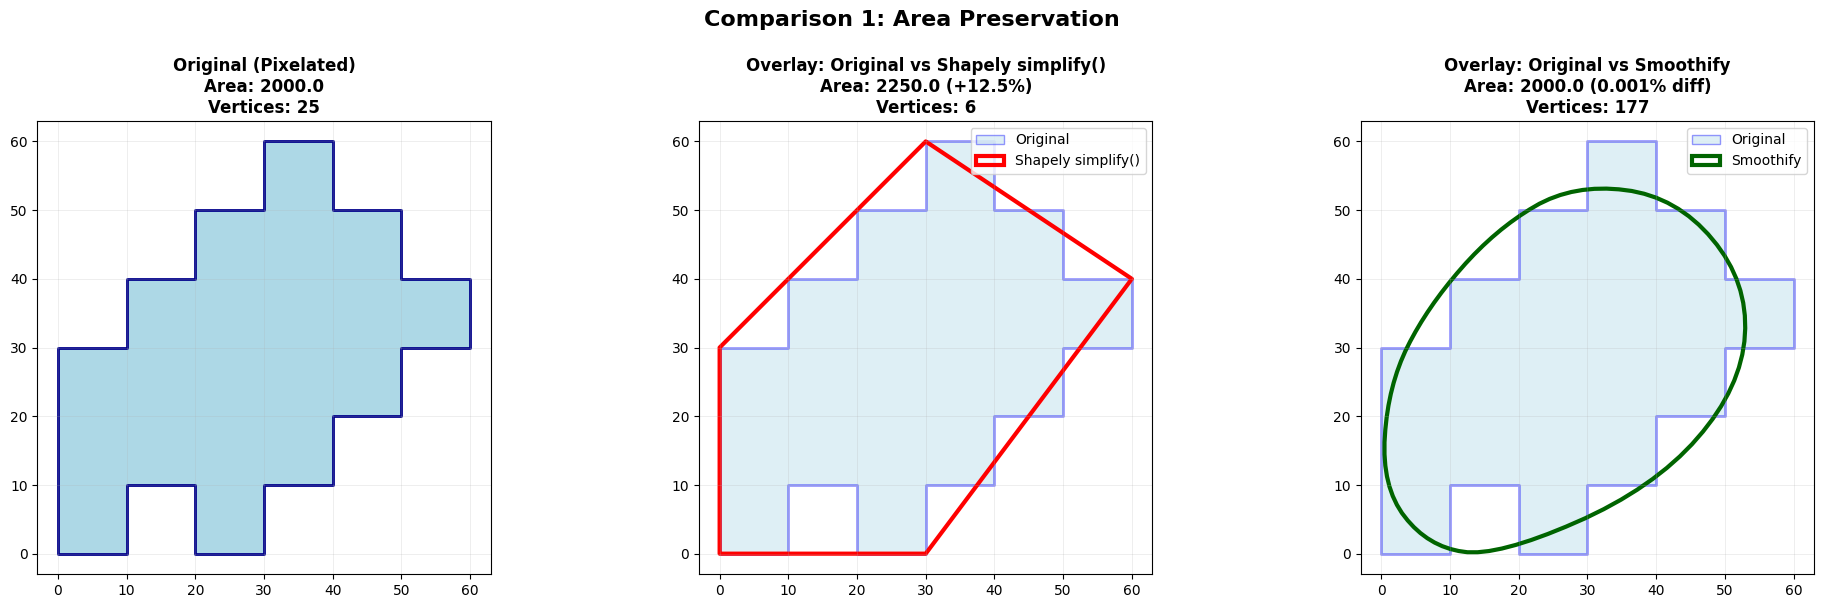


AREA COMPARISON
Original:                   2000.00 units²
Shapely simplify():         2250.00 units² ( +12.50%)
Smoothify:                  1999.99 units² (   0.00% diff)


In [3]:
# Create a stair-stepped polygon from raster-to-vector conversion
pixelated = Polygon(
    [
        (0, 0),
        (10, 0),
        (10, 10),
        (20, 10),
        (20, 0),
        (30, 0),
        (30, 10),
        (40, 10),
        (40, 20),
        (50, 20),
        (50, 30),
        (60, 30),
        (60, 40),
        (50, 40),
        (50, 50),
        (40, 50),
        (40, 60),
        (30, 60),
        (30, 50),
        (20, 50),
        (20, 40),
        (10, 40),
        (10, 30),
        (0, 30),
        (0, 0),
    ]
)

# Apply both methods
shapely_simplified = pixelated.simplify(tolerance=10.0, preserve_topology=True)
smoothified = smoothify(
    geom=pixelated,
    segment_length=10.0,
    smooth_iterations=3,
    preserve_area=True,
)

# Use helper function to plot
plot_comparison(
    pixelated,
    shapely_simplified,
    smoothified,
    "Comparison 1: Area Preservation",
    metric_name="Area",
)

## Example 2: Preserving Holes (Interior Rings)

**Key Feature**: Smoothify preserves the area of interior holes, while `simplify()` does not.

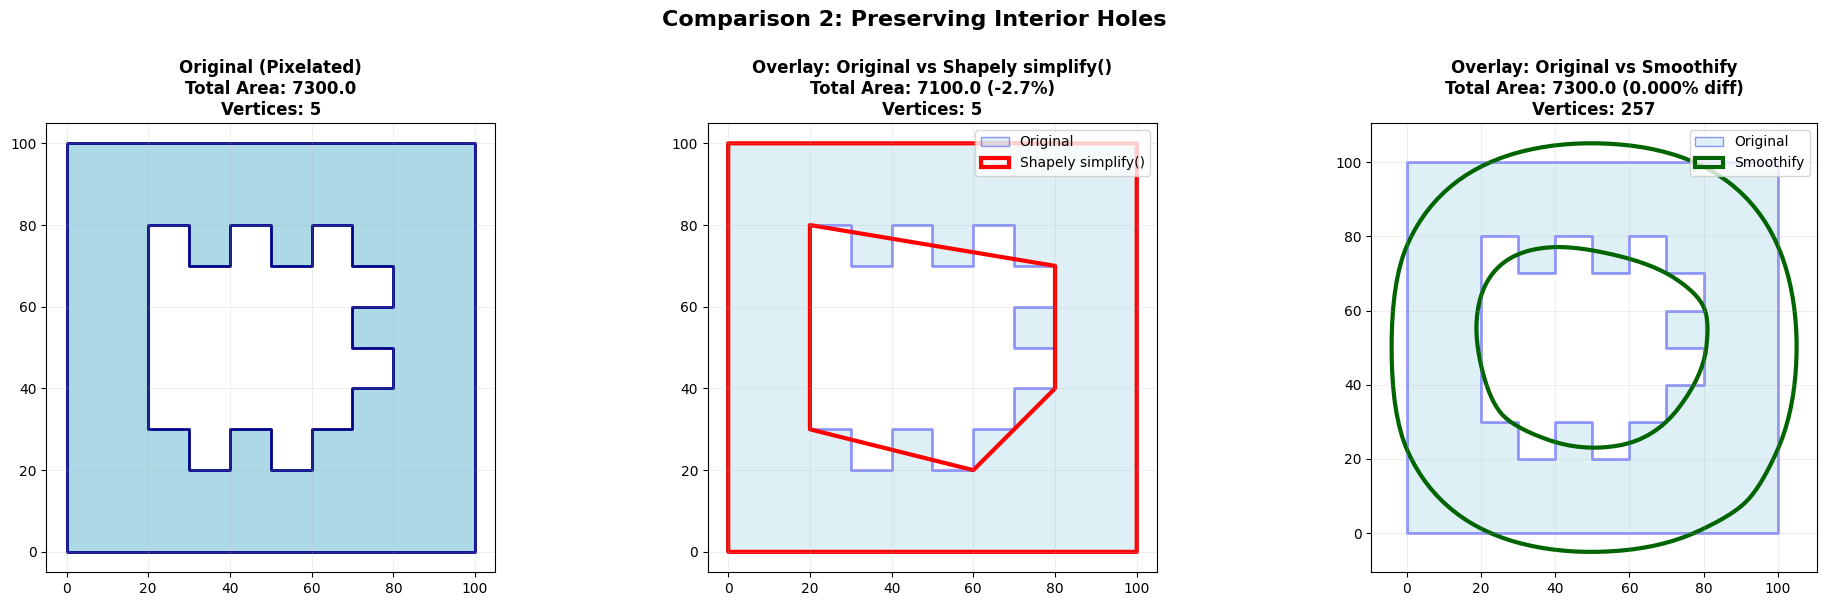


TOTAL AREA COMPARISON
Original:                   7300.00 units²
Shapely simplify():         7100.00 units² (  -2.74%)
Smoothify:                  7300.02 units² (   0.00% diff)

HOLE AREA COMPARISON
Original hole:              2700.00 units²
Shapely simplify() hole:    2900.00 units² (  +7.41%)
Smoothify hole:             2700.00 units² (  0.000% diff)


In [4]:
# Create a stair-stepped polygon with a complex hole (donut shape)
# Simple rectangular exterior
exterior = [(0, 0), (100, 0), (100, 100), (0, 100), (0, 0)]

# Complex irregular stair-stepped hole
hole = [
    (20, 30),
    (30, 30),
    (30, 20),
    (40, 20),
    (40, 30),
    (50, 30),
    (50, 20),
    (60, 20),
    (60, 30),
    (70, 30),
    (70, 40),
    (80, 40),
    (80, 50),
    (70, 50),
    (70, 60),
    (80, 60),
    (80, 70),
    (70, 70),
    (70, 80),
    (60, 80),
    (60, 70),
    (50, 70),
    (50, 80),
    (40, 80),
    (40, 70),
    (30, 70),
    (30, 80),
    (20, 80),
    (20, 70),
    (20, 60),
    (20, 50),
    (20, 40),
    (20, 30),
]

donut = Polygon(exterior, [hole])

# Apply both methods
donut_shapely = donut.simplify(tolerance=10.0, preserve_topology=True)
donut_smoothified = smoothify(
    geom=donut, segment_length=10.0, smooth_iterations=3, preserve_area=True
)

# Use helper function to plot
plot_comparison(
    donut,
    donut_shapely,
    donut_smoothified,
    "Comparison 2: Preserving Interior Holes",
    metric_name="Total Area",
)

# Print hole-specific metrics
original_hole_area = Polygon(donut.interiors[0]).area
shapely_hole_area = (
    Polygon(donut_shapely.interiors[0]).area if len(donut_shapely.interiors) > 0 else 0
)
smoothify_hole_area = (
    Polygon(donut_smoothified.interiors[0]).area
    if len(donut_smoothified.interiors) > 0
    else 0
)
hole_change_pct = (
    (shapely_hole_area - original_hole_area) / original_hole_area * 100
    if original_hole_area > 0
    else 0
)
hole_diff_pct = (
    abs(smoothify_hole_area - original_hole_area) / original_hole_area * 100
    if original_hole_area > 0
    else 0
)

print("\n" + "=" * 70)
print("HOLE AREA COMPARISON")
print("=" * 70)
print(f"Original hole:           {original_hole_area:>10.2f} units²")
print(
    f"Shapely simplify() hole: {shapely_hole_area:>10.2f} units² ({hole_change_pct:>+7.2f}%)"
)
print(
    f"Smoothify hole:          {smoothify_hole_area:>10.2f} units² ({hole_diff_pct:>7.3f}% diff)"
)

## Example 3: Consistency with Original Geometry

**Key Feature**: Smoothify combines simplification with smoothing to stay more consistent with the original shape.

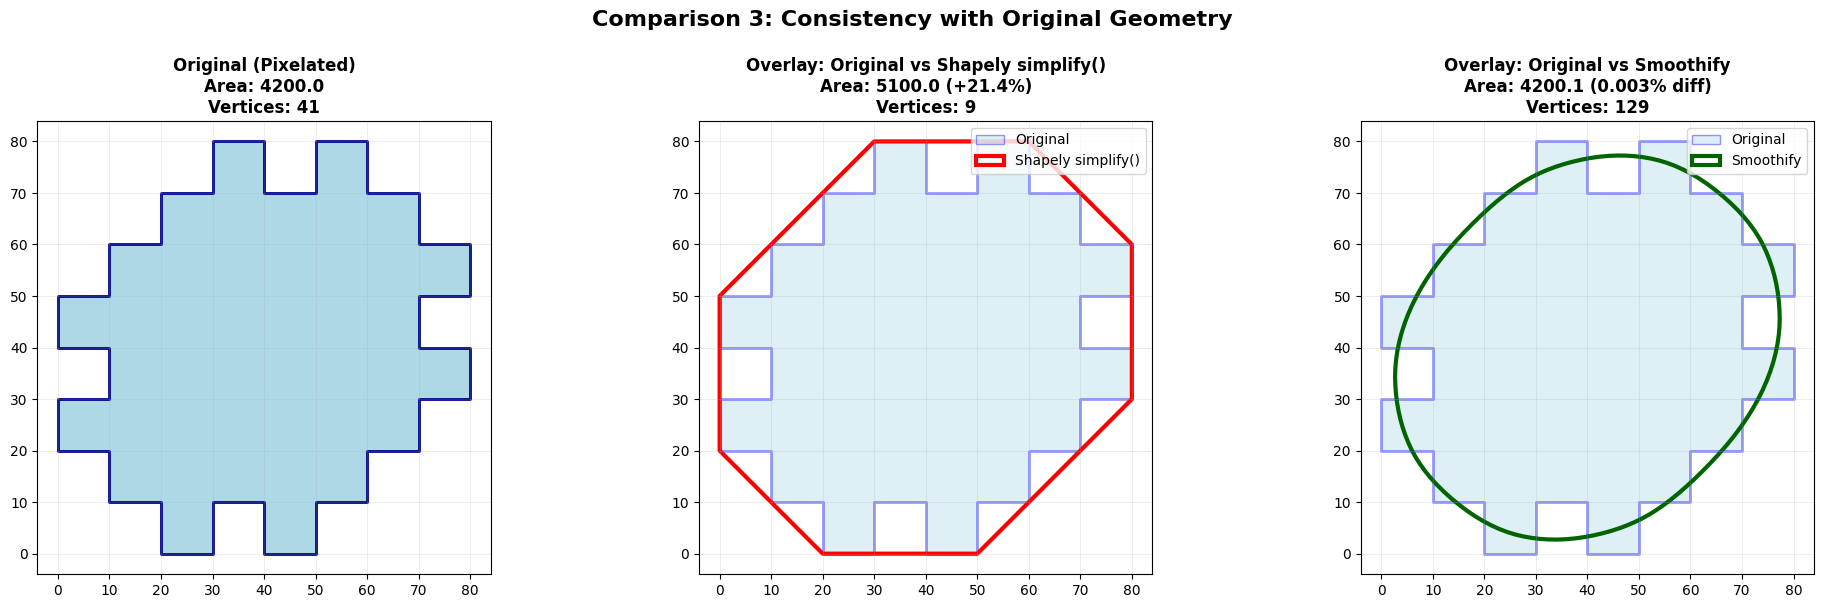


AREA COMPARISON
Original:                   4200.00 units²
Shapely simplify():         5100.00 units² ( +21.43%)
Smoothify:                  4200.13 units² (   0.00% diff)


In [5]:
# Create a complex stair-stepped polygon representing a natural feature
irregular = Polygon(
    [
        (0, 20),
        (10, 20),
        (10, 10),
        (20, 10),
        (20, 0),
        (30, 0),
        (30, 10),
        (40, 10),
        (40, 0),
        (50, 0),
        (50, 10),
        (60, 10),
        (60, 20),
        (70, 20),
        (70, 30),
        (80, 30),
        (80, 40),
        (70, 40),
        (70, 50),
        (80, 50),
        (80, 60),
        (70, 60),
        (70, 70),
        (60, 70),
        (60, 80),
        (50, 80),
        (50, 70),
        (40, 70),
        (40, 80),
        (30, 80),
        (30, 70),
        (20, 70),
        (20, 60),
        (10, 60),
        (10, 50),
        (0, 50),
        (0, 40),
        (10, 40),
        (10, 30),
        (0, 30),
        (0, 20),
    ]
)

# Apply both methods
irregular_shapely = irregular.simplify(tolerance=10.0, preserve_topology=True)
irregular_smoothified = smoothify(
    geom=irregular, segment_length=10.0, smooth_iterations=3, preserve_area=True
)

# Use helper function to plot
plot_comparison(
    irregular,
    irregular_shapely,
    irregular_smoothified,
    "Comparison 3: Consistency with Original Geometry",
    metric_name="Area",
)

## Example 4: Joining Adjacent Polygons

**Key Feature**: Smoothify can merge adjacent polygons, which is useful when:
- Thin objects get split during raster-to-vector conversion
- Linear features (roads, rivers) become fragmented
- You want to merge adjacent features with the same classification

Shapely's `simplify()` operates on each polygon independently and does not join adjacent polygons.

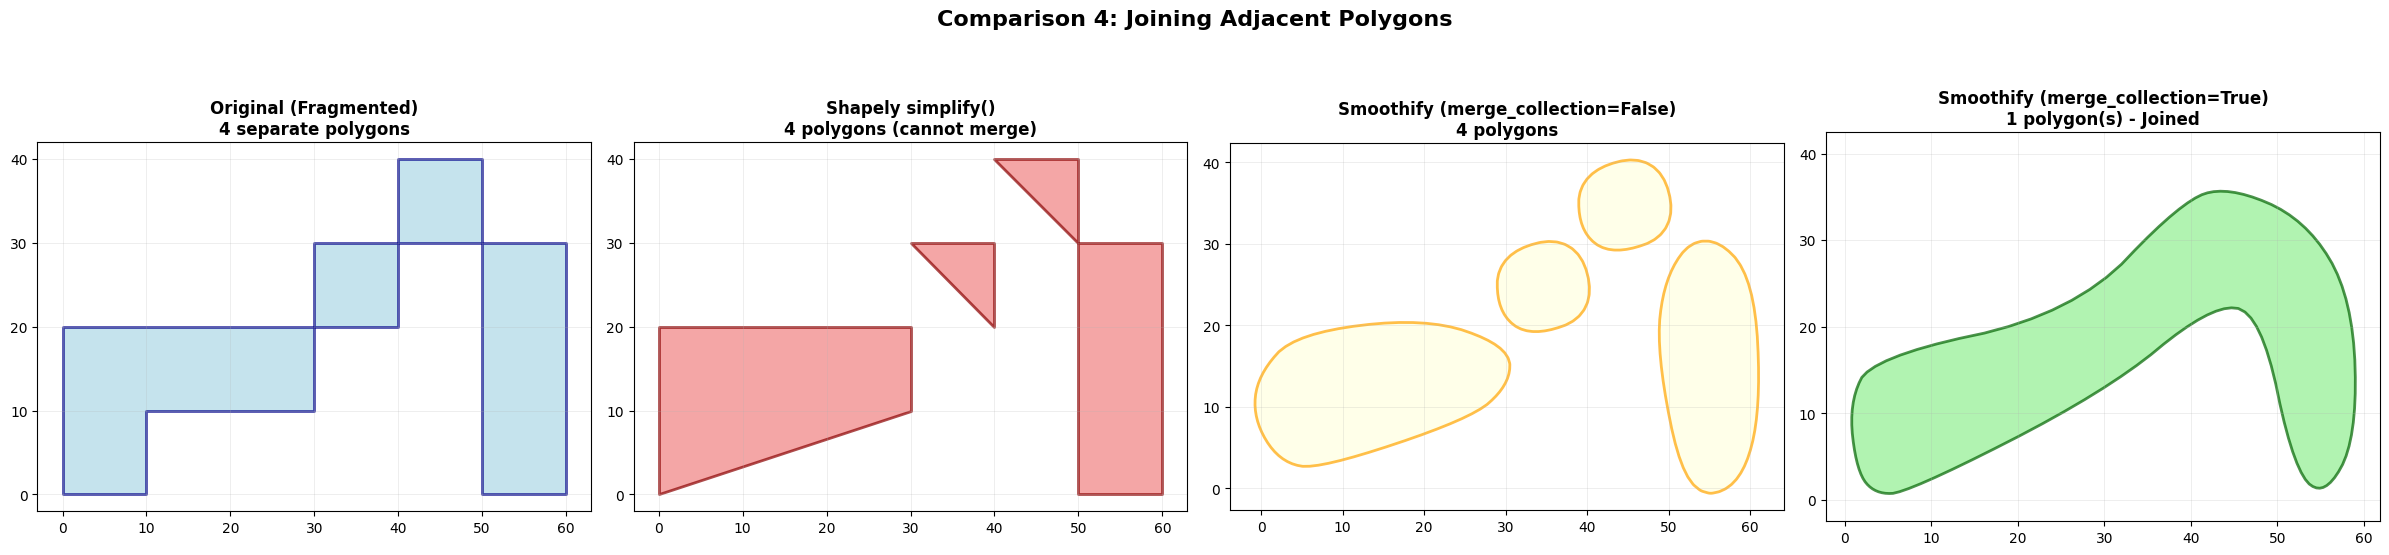

In [21]:
# Simulate a thin winding feature (e.g., river) that got fragmented during raster-to-vector conversion
# Each segment shares edges with adjacent segments (not just touching at corners)
from matplotlib import ticker

thin_segments = [
    Polygon(
        [
            (0, 0),
            (10, 0),
            (10, 10),
            (30, 10),
            (30, 20),
            (0, 20),
        ]
    ),
    Polygon([(30, 20), (40, 20), (40, 30), (30, 30)]),
    Polygon([(40, 30), (50, 30), (50, 40), (40, 40)]),
    Polygon([(50, 00), (60, 00), (60, 30), (50, 30)]),
]

# Apply shapely simplify to each polygon (cannot join)
shapely_segments = [
    seg.simplify(tolerance=8.0, preserve_topology=True) for seg in thin_segments
]

# Apply smoothify WITHOUT merging
smoothify_no_merge = smoothify(
    geom=thin_segments,
    segment_length=8.0,
    smooth_iterations=3,
    merge_collection=False,
)
smoothify_no_merge = list(smoothify_no_merge.geoms)
# Apply smoothify WITH merging
smoothify_with_merge = smoothify(
    geom=thin_segments,
    segment_length=8.0,
    smooth_iterations=3,
    merge_collection=True,
)

# Visualize with 4x1 layout
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Original fragmented
gpd.GeoSeries(thin_segments).plot(
    ax=axes[0], color="lightblue", edgecolor="darkblue", linewidth=2, alpha=0.7
)
axes[0].set_title(
    f"Original (Fragmented)\n{len(thin_segments)} separate polygons",
    fontweight="bold",
    fontsize=12,
)
axes[0].set_aspect("equal")
axes[0].grid(True, alpha=0.3, linewidth=0.5)

# Shapely simplify (still fragmented)
gpd.GeoSeries(shapely_segments).plot(
    ax=axes[1], color="lightcoral", edgecolor="darkred", linewidth=2, alpha=0.7
)
axes[1].set_title(
    f"Shapely simplify()\n{len(shapely_segments)} polygons (cannot merge)",
    fontweight="bold",
    fontsize=12,
)
axes[1].set_aspect("equal")
axes[1].grid(True, alpha=0.3, linewidth=0.5)

# Smoothify without merge
if isinstance(smoothify_no_merge, list):
    gpd.GeoSeries(smoothify_no_merge).plot(
        ax=axes[2], color="lightyellow", edgecolor="orange", linewidth=2, alpha=0.7
    )
    n_geoms = len(smoothify_no_merge)
else:
    gpd.GeoSeries([smoothify_no_merge]).plot(
        ax=axes[2], color="lightyellow", edgecolor="orange", linewidth=2, alpha=0.7
    )
    n_geoms = 1

axes[2].set_title(
    f"Smoothify (merge_collection=False)\n{n_geoms} polygons",
    fontweight="bold",
    fontsize=12,
)
axes[2].set_aspect("equal")
axes[2].grid(True, alpha=0.3, linewidth=0.5)
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(10))

# Smoothify with merge
if isinstance(smoothify_with_merge, list):
    gpd.GeoSeries(smoothify_with_merge).plot(
        ax=axes[3], color="lightgreen", edgecolor="darkgreen", linewidth=2, alpha=0.7
    )
    n_merged = len(smoothify_with_merge)
else:
    gpd.GeoSeries([smoothify_with_merge]).plot(
        ax=axes[3],
        color="lightgreen",
        edgecolor="darkgreen",
        linewidth=2,
        alpha=0.7,
    )
    n_merged = 1

axes[3].set_title(
    f"Smoothify (merge_collection=True)\n{n_merged} polygon(s) - Joined",
    fontweight="bold",
    fontsize=12,
)
axes[3].set_aspect("equal")
axes[3].grid(True, alpha=0.3, linewidth=0.5)
axes[3].set_ylim(-2.5, 42.5)

axes[3].yaxis.set_major_locator(ticker.MultipleLocator(10))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(10))
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(10))


plt.suptitle(
    "Comparison 4: Joining Adjacent Polygons",
    fontsize=16,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()